## Preparation

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px

In [ ]:
!pip install plotly-express ipywidgets jupyter-dash

In [3]:
%reload_ext sql
%sql duckdb://

## 修改查询结果展示条数

In [8]:
%config SqlMagic.displaylimit = None

displaylimit: Value None will be treated as 0 (no limit)

In [ ]:

%%sql
select id, name, stargazers, forks, releases
  from ghgolang1.csv
 where isFork = 'FALSE'
 order by stargazers desc, forks desc
 limit 100


### Find Earliest Golang Repository

In [ ]:
%%sql
select id, name, stargazers, forks, releases, createdAt
  from ghgolang1.csv
 order by createdAt desc, stargazers desc, forks desc
 limit 100


In [10]:
%%sql
select count(id)
  from ghgolang1.csv


Running query in 'duckdb://'

count(id)


In [ ]:
%%sql
select t2.full_name   as github_name,
       t1.dep_module  as lib_public_name,
       t1.dep_version as lib_version,
       t1.full_name   as ref_name,
       t1.version     as ref_version
  from read_csv_auto('dependencies2.csv', header=True) t1
 inner join read_csv_auto('dependencies2.csv', header=True) t2
    on t1.dep_module = t2.public_name and t2.fork = 0
 order by 1
  limit 1000



In [ ]:
%%sql
select id,
       full_name,
       fork,
       stargazers_count,
       forks_count,
       watchers_count,
       open_issues_count,
       size,
       topics,
       default_branch,
       language,
       license,
       pushed_at,
       created_at,
       updated_at,
       has_discussions,
       has_downloads,
       has_issues,
       has_pages,
       has_projects,
       has_wiki,
       is_template,
       web_commit_signoff_required
  from read_csv_auto('repo-candidates/final.csv', header=True)
 order by stargazers_count desc
 limit 20

## Topic analysis

In [93]:
def split_by_topics(row):
    topics = row['topics']
    row['topic'] = [m.group(1) for m in re.finditer(r"'([-\w]+)'", topics)]
    if len(row['topic']) == 0: row['topic'] = 'NOTOPIC'
    return row

def expand(file):
    df = pd.read_csv(file, parse_dates=['created_at', 'updated_at', 'pushed_at'])
    df = df.apply(lambda row: split_by_topics(row), axis=1)
    df = df.explode(['topic'])
    return df

In [ ]:
df = expand("repo-candidates/final.csv")

In [173]:
sum = df.groupby("topic").agg(
    repositories=pd.NamedAgg(column="id", aggfunc="count"),
    stars=pd.NamedAgg(column="stargazers_count", aggfunc="sum"),
    folks=pd.NamedAgg(column="forks_count", aggfunc="sum"),
    watchers=pd.NamedAgg(column="watchers_count", aggfunc="sum"),
).sort_values("repositories", ascending=False)

In [181]:
stats = sum.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])
stats = stats.astype('int32')

In [ ]:
stats.to_latex("__stats.tex")

In [185]:
sum.query("repositories > 2").head(20).to_latex("__top20.tex")

In [127]:
df['year'] = df['created_at'].dt.year
sum2 = df.groupby(["year", "topic"]).agg(
    topic_members=pd.NamedAgg(column="id", aggfunc="count"),
    topic_stars=pd.NamedAgg(column="stargazers_count", aggfunc="sum"),
    topic_forks=pd.NamedAgg(column="forks_count", aggfunc="sum"),
)

In [156]:

df_vis = sum2.query("topic_members > 15")
df_vis.reset_index(level=1, inplace=True)
df_vis.reset_index(level=0, inplace=True)

# remove NOTOPIC, go, golang as they overlap too much
df_vis = df_vis.query("topic != 'NOTOPIC' and topic != 'go' and topic != 'golang'")

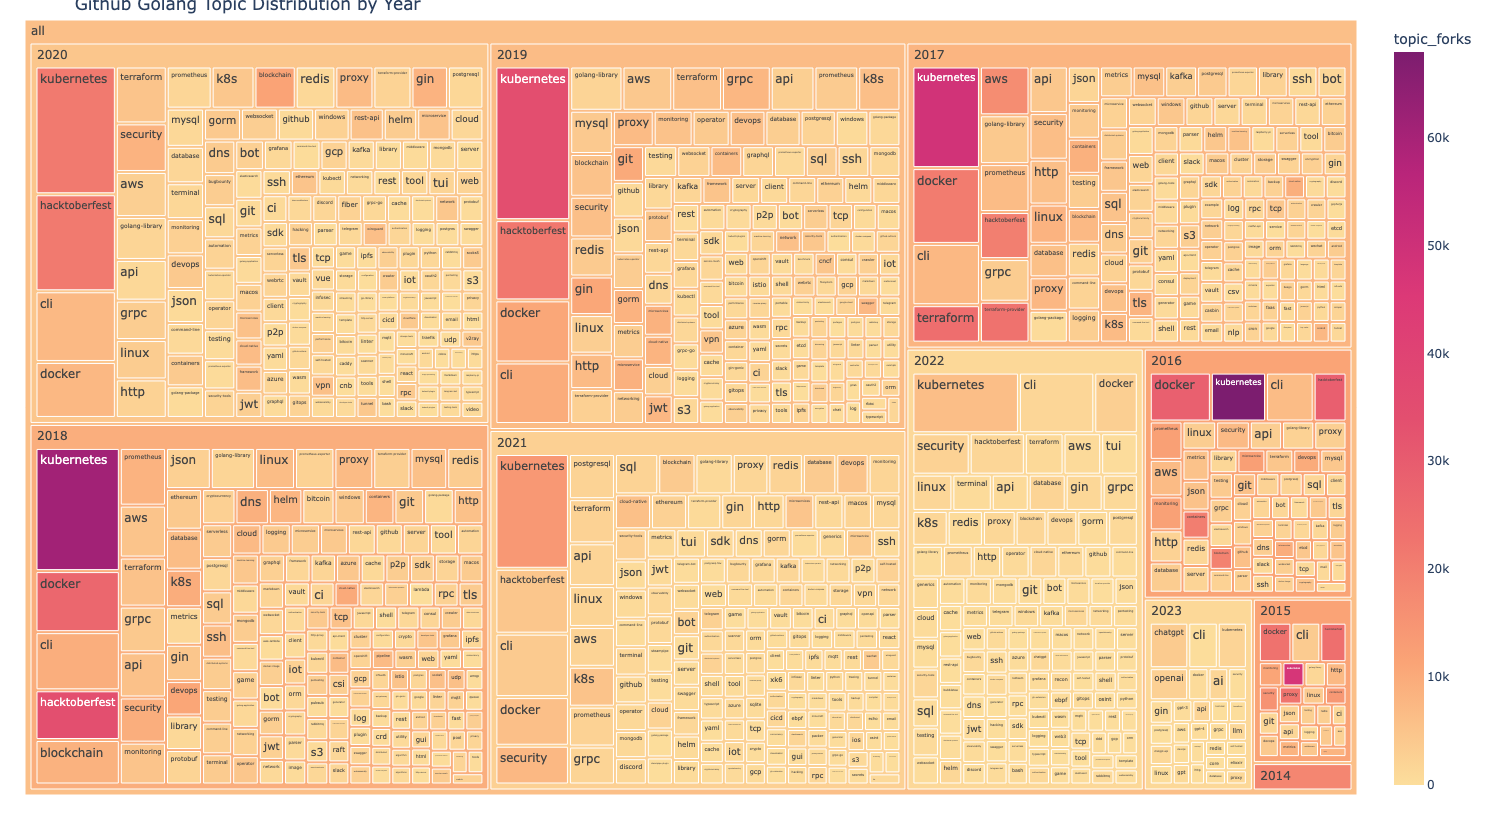

In [157]:

fig = px.treemap(
    df_vis, path=[px.Constant("all"), 'year', 'topic'],
    values='topic_members',
    #color_continuous_scale=px.colors.sequential.Sunset,
    color_continuous_scale=px.colors.sequential.Sunsetdark,
    color='topic_forks',
    width=1200, height=820,
    title="Github Golang Topic Distribution by Year")
fig.update_layout(margin = dict(t=20, l=25, r=25, b=25))
fig.show()

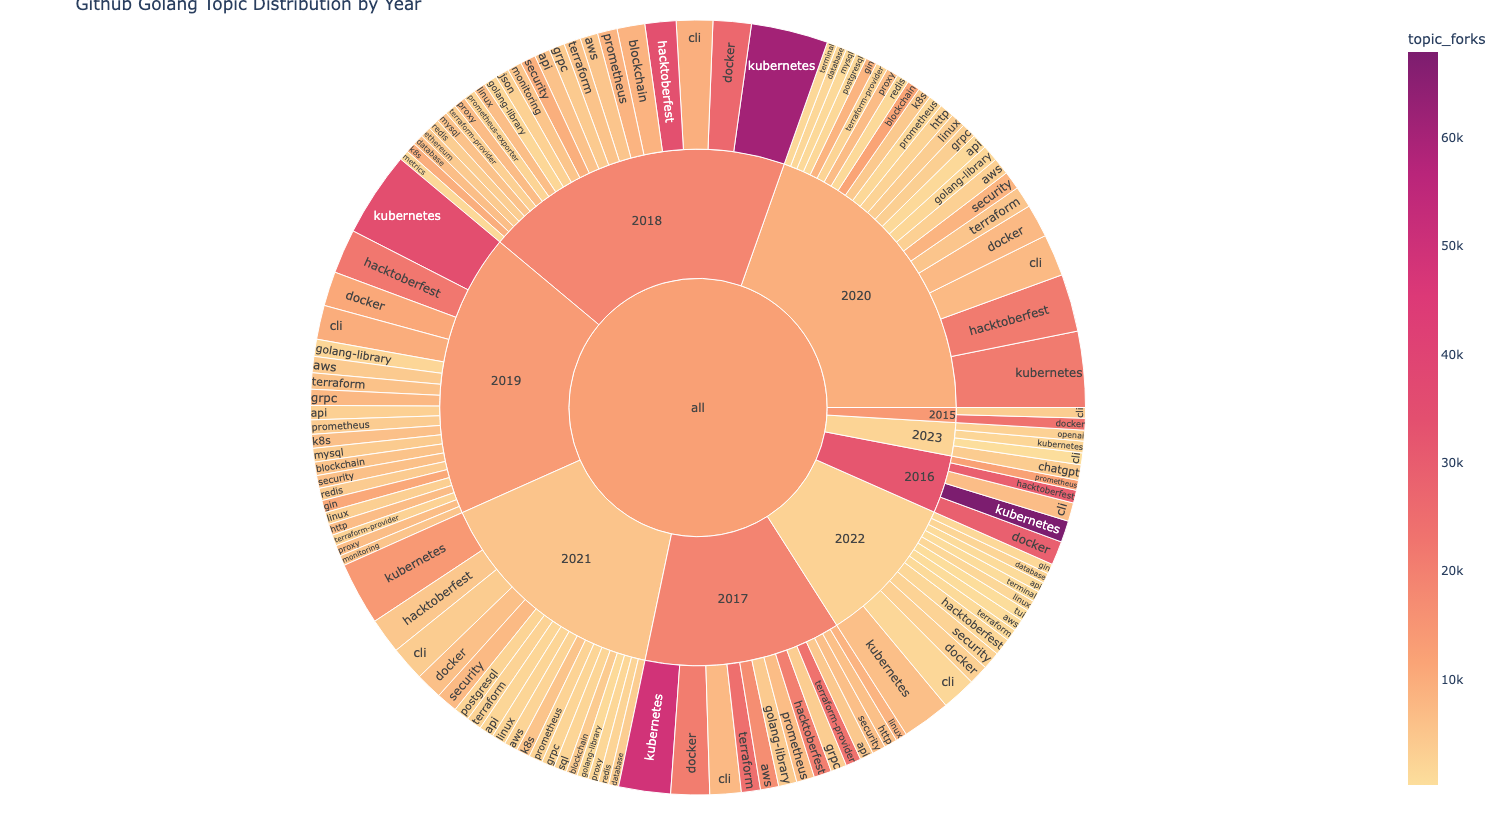

In [162]:
df_vis2 = df_vis.query("topic_members > 59")
fig = px.sunburst(
    df_vis2, path=[px.Constant("all"), 'year', 'topic'],
    values='topic_members',
    #color_continuous_scale=px.colors.sequential.Sunset,
    color_continuous_scale=px.colors.sequential.Sunsetdark,
    color='topic_forks',
    width=1200, height=820,
    title="Github Golang Topic Distribution by Year")
fig.update_layout(margin = dict(t=20, l=25, r=25, b=25))
fig.show()

In [ ]:
for i, t in enumerate(df["topics"].unique()):
    print(i, t)

In [47]:
%%sql res <<
select full_name as repo,
       stargazers_count as "stars",
       forks_count as "forks",
       topics,
       watchers_count as "watchers",
       open_issues_count as "issues",
       strftime(created_at, '%Y-%m-%d') as "Start"
  from read_csv_auto('repo-candidates/final.csv', header=True)
 order by stargazers_count desc
 limit 30

Running query in 'duckdb://'

In [54]:
df = res.DataFrame()
print(df['topics'][0])

['go', 'golang', 'language', 'programming-language']


In [ ]:

print(df.to_latex(index=False))

In [ ]:
%%sql
select id,
       full_name,
       score
  from read_csv_auto('repo-candidates/final.csv', header=True)
 order by score desc
 limit 100

In [ ]:
%%sql
select fork,
       count(*)
  from read_csv_auto('repo-candidates/slim.csv', header=True)
  group by fork



In [188]:
%%sql

select *
  from read_csv_auto('name-conv-progress.csv', header=True)
 where github_name = '-'
   and fail_reason is not null

-- select module,
--        regexp_extract(module, '([a-z0-9\.]+)/.*', 1) as prefix
--   from read_csv_auto('name-conv-progress.csv', header=True)
--  where github_name not like 'github.com/%'
--    and github_name = module
--    and regexp_extract(module, '([a-z0-9\.]+)/.*', 1) = 'humungus.tedunangst.com'


Running query in 'duckdb://'

module,github_name,fail_reason,last_updated


In [ ]:
%%sql
select distinct t2.full_name   as github_name,
       t1.dep_module  as lib_public_name,
       t1.full_name   as ref_name,
  from read_csv_auto('dependencies2.csv', header=True) t1
 inner join read_csv_auto('dependencies2.csv', header=True) t2
    on t1.dep_module = t2.public_name and t2.fork = 0
 where not t1.dep_module like 'github.com/%'
 order by 1
  limit 1000


In [189]:
df1 = pd.read_csv("name-conv-progress.csv")
df2 = pd.read_csv("module-refs.csv")

df3 = df2.merge(df1, how="left", on="module")
df3.query("github_name == github_name")

,module,refs,github_name,fail_reason,last_updated
0,k8s.io/apimachinery,49117,github.com/kubernetes/apimachinery,NaN,2023-08-27 22:47:26
1,k8s.io/client-go,47051,github.com/kubernetes/client-go,NaN,2023-08-27 22:47:27
2,gopkg.in/yaml.v2,45263,github.com/go-yaml/yaml,NaN,2023-08-27 22:47:27
3,k8s.io/api,44666,github.com/kubernetes/api,NaN,2023-08-27 22:47:27
4,google.golang.org/grpc,43968,github.com/grpc/grpc-go,NaN,2023-08-27 22:47:28
...,...,...,...,...,...
1739,open-cluster-management.io/placement,1,github.com/open-cluster-management-io/placement,NaN,2023-08-27 23:15:14
1740,gitlab.com/thorchain/txscript,1,gitlab.com/thorchain/txscript.git,NaN,2023-08-27 23:16:32
1741,gopkg.in/inconshreveable/go-update.v0,1,github.com/inconshreveable/go-update,NaN,2023-08-27 23:08:44
1742,go.opentelemetry.io/collector/config/configauth,1,github.com/open-telemetry/opentelemetry-collector,NaN,2023-08-27 23:16:41


In [111]:
%%sql result <<
select dep_module as module,
       count(*) as refs
  from read_csv_auto('dependencies.csv', header=True)
 where module not like 'github.com/%'
 group by dep_module
 order by 2 desc

 -- 

Running query in 'duckdb://'

In [112]:
df = result.DataFrame()
# df.to_csv("module-refs.csv", index=False)
df

,module,refs
0,k8s.io/apimachinery,49117
1,k8s.io/client-go,47051
2,golang.org/x/crypto,46343
3,gopkg.in/yaml.v2,45263
4,k8s.io/api,44666
...,...,...
1765,go.abhg.dev/goldmark/wikilink,1
1766,go.jolheiser.com/hcaptcha,1
1767,fyne.io/cloud,1
1768,stash.appscode.dev/apimachinery,1


In [33]:
df = result.DataFrame()
df.head(10).to_latex("abc.tex", index=False)

In [15]:
%%sql result <<
select t1.full_name   as full_name,
       t1.public_name as public_name,
       t1.version     as version,
       case when t2.fork = 'False' then 0 else 1 end as fork,
       t1.dep_module  as dep_module,
       t1.dep_version as dep_version
  from read_csv_auto('dependencies.csv', header=True) t1
 inner join read_csv_auto('repo-candidates/slim.csv', header=True) t2
    on t1.full_name = t2.full_name


Running query in 'duckdb://'

## Vulnerability analysis

In [5]:
%%sql
select t1.full_name as dependent_module,
       t1.version as dependent_version,
       t2.module as vul_module,
       t1.dep_version as ref_version,
       t2.fix_version,
       t2.vul_id,
       t2.alias,
       t2.published
  from read_csv_auto('mod-info.oci/dependencies.csv', header=True) t1
 inner join read_csv_auto('govuls.csv', header=True) t2
    on t2.module = t1.dep_module

Running query in 'duckdb://'

RuntimeError: (duckdb.InvalidInputException) Invalid Input Error: Attempting to execute an unsuccessful or closed pending query result
Error: Invalid Error: Current transaction is aborted (please ROLLBACK)
[SQL: select t1.full_name as dependent_module,
       t1.version as dependent_version,
       t2.module as vul_module,
       t1.dep_version as ref_version,
       t2.fix_version,
       t2.vul_id,
       t2.alias,
       t2.published
  from read_csv_auto('mod-info.oci/dependencies.csv', header=True) t1
 inner join read_csv_auto('govuls.csv', header=True) t2
    on t2.module = t1.dep_module]
(Background on this error at: https://sqlalche.me/e/20/f405)
If you need help solving this issue, send us a message: https://ploomber.io/community


In [ ]:
%%sql
select module,
       count(*),
       max(published),
       max(fix_version)
  from read_csv_auto('govuls.csv', header=True)
 group by module
 order by 2 desc